#Importing Packages

In [1]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [3]:
!wget https://dlcdn.apache.org/spark/spark-3.3.0/spark-3.3.0-bin-hadoop2.tgz

--2022-10-20 05:00:43--  https://dlcdn.apache.org/spark/spark-3.3.0/spark-3.3.0-bin-hadoop2.tgz
Resolving dlcdn.apache.org (dlcdn.apache.org)... 151.101.2.132, 2a04:4e42::644
Connecting to dlcdn.apache.org (dlcdn.apache.org)|151.101.2.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 274079476 (261M) [application/x-gzip]
Saving to: ‘spark-3.3.0-bin-hadoop2.tgz.7’

spark-3.3.0-bin-had 100%[===================>] 261.38M   178MB/s    in 1.5s    

2022-10-20 05:00:44 (178 MB/s) - ‘spark-3.3.0-bin-hadoop2.tgz.7’ saved [274079476/274079476]



In [4]:
!tar xf spark-3.3.0-bin-hadoop2.tgz

In [5]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "spark-3.3.0-bin-hadoop2"

In [6]:
!pip install petastorm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
!pip install findspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
import findspark
findspark.init()

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .config("spark.csci316.pandas.SVM", "false") \
    .getOrCreate()
spark

#Load the dataset and start the graph session

In [11]:
#Read the csv file
data = spark.read.csv("/content/drive/MyDrive/cleanWithHeader.csv", inferSchema=True, header=True)

In [12]:
from petastorm.spark import SparkDatasetConverter, make_spark_converter
import os
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
import math
import matplotlib.pyplot as plt

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

/usr/local/lib/python3.7/dist-packages/petastorm/spark/spark_dataset_converter.py:28: FutureWarning: pyarrow.LocalFileSystem is deprecated as of 2.0.0, please use pyarrow.fs.LocalFileSystem instead.
  from pyarrow import LocalFileSystem
Instructions for updating:
non-resource variables are not supported in the long term


In [13]:
sess = tf.Session()

In [14]:
data.show(10)

+-------+---------+---------+-----------+---------------+--------+-----------+----------+-----+-----------+--------------+--------+-------+---------+---------+---------+-------------+-----------+---------------+---------------+-------------+------------------+----------+-----------------------+-----------+------------------+-----------------------+----------------------------------+-------------------+--------------------+-------------------+------------------------+----------------+----------------------+--------------------+-----------+-------------+--------------------+----------------+-------------------------+---------------+----------+-------------------------+
|     id|member_id|loan_amnt|funded_amnt|funded_amnt_inv|int_rate|installment|annual_inc|  dti|delinq_2yrs|inq_last_6mths|open_acc|pub_rec|revol_bal|total_acc|out_prncp|out_prncp_inv|total_pymnt|total_pymnt_inv|total_rec_prncp|total_rec_int|total_rec_late_fee|recoveries|collection_recovery_fee|default_ind|revol_util_impute

In [15]:
#Re-arrange the dataset
data_reordered = data.select("id","member_id","loan_amnt","funded_amnt","funded_amnt_inv","int_rate","installment","annual_inc",
                             "dti","delinq_2yrs","inq_last_6mths","open_acc","pub_rec","revol_bal","total_acc","out_prncp","out_prncp_inv",
                             "total_pymnt","total_pymnt_inv","total_rec_prncp","total_rec_int","total_rec_late_fee","recoveries",
                             "collection_recovery_fee","revol_util_imputed","last_pymnt_amnt_imputed","collections_12_mths_ex_med_imputed",
                             "policy_code_imputed","tot_coll_amt_imputed","tot_cur_bal_imputed","total_rev_hi_lim_imputed","pymnt_plan_index",
                             "application_type_index","acc_now_delinq_index","grade_index","purpose_index","home_ownership_index",
                             "emp_length_index","verification_status_index","sub_grade_index","term_index","initial_list_status_index", "default_ind")

#Split data into train set and test set

In [16]:
df_train, df_val = data_reordered.randomSplit([0.7, 0.3], seed=135)

df_train = df_train.repartition(2)
df_val = df_val.repartition(2)

In [17]:
df_train.show()

+--------+---------+---------+-----------+---------------+--------+-----------+----------+-----+-----------+--------------+--------+-------+---------+---------+---------+-------------+-----------+---------------+---------------+-------------+------------------+----------+-----------------------+------------------+-----------------------+----------------------------------+-------------------+--------------------+-------------------+------------------------+----------------+----------------------+--------------------+-----------+-------------+--------------------+----------------+-------------------------+---------------+----------+-------------------------+-----------+
|      id|member_id|loan_amnt|funded_amnt|funded_amnt_inv|int_rate|installment|annual_inc|  dti|delinq_2yrs|inq_last_6mths|open_acc|pub_rec|revol_bal|total_acc|out_prncp|out_prncp_inv|total_pymnt|total_pymnt_inv|total_rec_prncp|total_rec_int|total_rec_late_fee|recoveries|collection_recovery_fee|revol_util_imputed|last_pym

In [18]:
print(f"train: {df_train.count()}, val: {df_val.count()}")

train: 598745, val: 256998


In [19]:
train_dataset = df_train.toPandas()

In [20]:
test_dataset = df_val.toPandas()

In [21]:
x_train = train_dataset.iloc[:,0:42].values 
y_train = train_dataset.iloc[:,-1].values 

In [22]:
x_test = test_dataset.iloc[:,0:42].values 
y_test = test_dataset.iloc[:,-1].values 

#Set batch size, placeholders and model variables

In [23]:
batch_size = 100

#There are 42 features (columns) that are utilized for the model
#these placeholders serves to contain fed data that will be use for computational purpose
x_data = tf.placeholder(shape=[None, 42], dtype=tf.float32)
y_target = tf.placeholder(shape=[None, 1], dtype=tf.float32)

#Create model variables which are slope and constant of the linear equation
#that are initialized when session starts and the values get adjusted to find the best fit line 
#or hyperplane by maximizing the margin which classifies the prediction
A = tf.Variable(tf.random_normal(shape=[42,1]))
b = tf.Variable(tf.random_normal(shape=[1,1]))

In [24]:
#model output declaration
model_output = tf.subtract(tf.matmul(x_data, A), b)
#the feature data is multiplied with the intercept variable and the result is subtracted with the constant variable for the output

In [25]:
#maximum margin loss
l2_norm = tf.reduce_sum (tf.square(A))

#alpha determine whether the margin crossing the margin line will be a soft of hard allowance
#the larger the value the more emphasis on widening the margin 
#the smaller  the values result in the model having a hard margin while allowing data points to cross the margin 
alpha = tf.constant([0.1])
classification_term = tf.reduce_mean(tf.maximum(0.,tf.subtract(1.,tf.multiply(model_output, y_target))))

#loss function
loss = tf.add(tf.multiply(alpha, l2_norm), classification_term)

In [26]:
#prediction and accuracy
prediction = tf.sign(model_output)
accuracy = tf.reduce_mean(tf.cast(tf.equal(prediction, y_target), tf.float32))

In [27]:
#declare optimizer and initialize model variables
my_opt = tf.train.GradientDescentOptimizer(0.01)
train_step = my_opt.minimize(loss)

#initialize variables
init = tf.global_variables_initializer()
sess.run(init)

#Training

In [28]:
#training loop 

#Storing values for data visualization later on
loss_vec = []
train_acc = []
test_acc = []

for i in range(1000):
  rand_index = np.random.choice(len(x_train), size=batch_size)
  rand_x = x_train[rand_index]
  rand_y = np.transpose([y_train[rand_index]])
  sess.run(train_step, feed_dict = {x_data: rand_x, y_target:rand_y})

  temp_loss = sess.run(loss, feed_dict = {x_data: rand_x, y_target:rand_y})
  loss_vec.append(temp_loss)

  train_acc_temp = sess.run(accuracy, feed_dict = {x_data: x_train, y_target: np.transpose([y_train])})
  train_acc.append(train_acc_temp)

  test_acc_temp = sess.run(accuracy, feed_dict={
      x_data:x_test,
      y_target: np.transpose([y_test])})
  test_acc.append(test_acc_temp)

  if (i+1) % 100 == 0:
    # print('Step #{} A = {}, b = {}'.format(
    #     str(i+1),
    #     str(sess.run(A)),
    #     str(sess.run(b))
    # ))
    print('Accuracy = ' + str(train_acc_temp))
    print('Loss = ' + str(temp_loss))

Accuracy = 0.054415487
Loss = [15880118.]
Accuracy = 0.054415487
Loss = [10640497.]
Accuracy = 0.054415487
Loss = [7129684.5]
Accuracy = 0.054415487
Loss = [4777255.5]
Accuracy = 0.054415487
Loss = [3201008.2]
Accuracy = 0.054415487
Loss = [2144840.2]
Accuracy = 0.054415487
Loss = [1437153.4]
Accuracy = 0.054415487
Loss = [962967.44]
Accuracy = 0.054415487
Loss = [645238.2]
Accuracy = 0.054415487
Loss = [432343.22]


In [29]:
[[a1],[a2],[a3],[a4],[a5],[a6],[a7],[a8],[a9],[a10],[a11],[a12],[a13],[a14],[a15],[a16],[a17],[a18],[a19],[a20],[a21],[a22],[a23],[a24],[a25]
 ,[a26],[a27],[a28],[a29],[a30],[a31],[a32],[a33],[a34],[a35],[a36],[a37],[a38],[a39],[a40],[a41],[a42]]= sess.run(A)
slope = -a2/a1
y_intercept = b/a1
x1_test = [d[1] for d in x_test]
best_fit = []
for i in x1_test:
  best_fit.append(slope*i+y_intercept)
yes_loan_x = [d[1] for i, d in enumerate(x_test) if y_test[i] == 1]
yes_loan_y = [d[0] for i, d in enumerate(x_test) if y_test[i] == 1]
no_loan_x = [d[1] for i, d in enumerate(x_test) if y_test[i] == -1]
no_loan_y = [d[0] for i, d in enumerate(x_test) if y_test[i] == -1]

#best_fit

In [30]:
%matplotlib inline

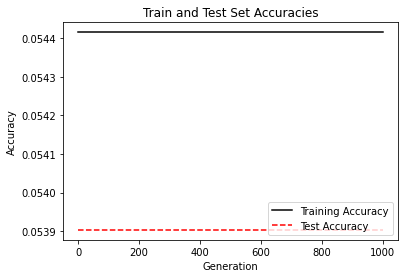

In [31]:
plt.plot(train_acc, 'k-', label= 'Training Accuracy')
plt.plot(test_acc, 'r--', label='Test Accuracy')
plt.title('Train and Test Set Accuracies')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

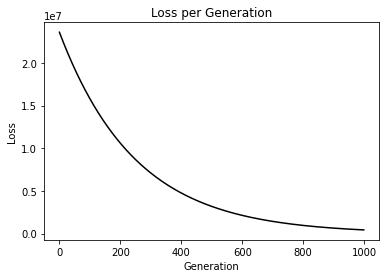

In [32]:
plt.plot(loss_vec, 'k-')
plt.title('Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Loss')
plt.show()